In [1]:
#| defualt_exp xgb_model

In [1]:
#| export
from fastai.tabular.all import *

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


import xgboost as xgb

import seaborn as sns

import optuna

import json

In [2]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [3]:
#| export
comp = 'playground-series-s3e11'
path = setup_comp(comp, install='fastai')

In [4]:
#| export
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_comb = pd.concat([df_train, df_test], ignore_index=True)

In [5]:
#| export
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)
df_comb.drop(['id'], axis=1, inplace=True)

In [6]:
#| export
df_train['store_sales_per_children'] = df_train['store_sales(in millions)'] / df_train['total_children']

In [7]:
#| export
for column in df_train.columns:
    if (list(df_train[column].unique()) == [0.0, 1.0]):
        df_train.loc[:, column] = df_train[column].astype('bool')

In [8]:
#| export
train_idxs = np.arange(len(df_train))
test_idxs = np.arange(len(df_train), len(df_comb))

In [9]:
#| export
dep_var = 'cost'
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(df_comb, max_card=1, dep_var=dep_var)
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))

In [10]:
#| export
df_train = df_comb.iloc[train_idxs]
df_test = df_comb.iloc[test_idxs]

In [11]:
#| export
to_final = TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)
test_final = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)
dls_final = to_final.dataloaders(bs=1024)

In [12]:
#| export
train_fi = df_train.drop(columns = ['cost'])
target_fi = df_train['cost']

In [13]:
#| export
def plot_fi(data,ax = None, title = None):
    fi = pd.Series(data, index = train_fi.columns).sort_values(ascending = True)
    fi.plot(kind = 'barh', ax = ax)

In [14]:
#| export
x_train, x_test, y_train, y_test = train_test_split(train_fi, target_fi, test_size=0.2)

In [15]:
#| export
fi_params = {'learning_rate': 0.2456172216493356,
 'max_depth': 10,
 'lambda': 0.0023120639864473262,
 'alpha': 0.5848465230832824,
 'colsample_bytree': 0.9966638720347625,
 'min_child_weight': 0,
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [16]:
#| export
model = xgb.XGBRegressor(**fi_params)


In [17]:
#| export
model.fit(x_train, y_train)

XGBRegressor(alpha=0.5848465230832824, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9966638720347625, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.0023120639864473262,
             learning_rate=0.2456172216493356, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

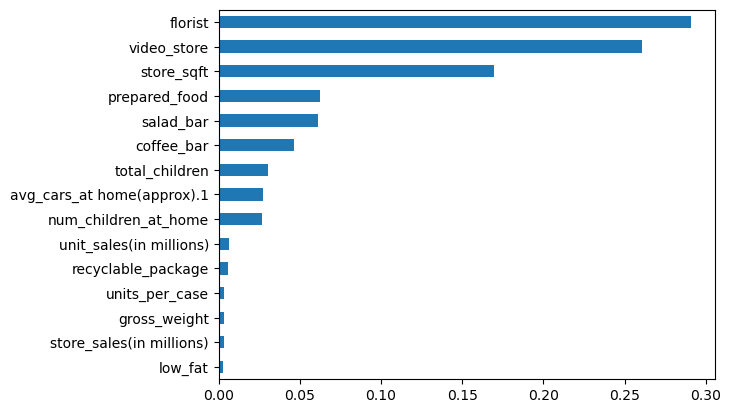

In [18]:
plot_fi(model.feature_importances_)

In [19]:
#| export
r = permutation_importance(model, x_test, y_test, n_repeats=1, random_state=46)

In [20]:
#| export
fi = pd.Series(r['importances'].reshape(15,), index = train_fi.columns).sort_values(ascending = True)

<AxesSubplot: >

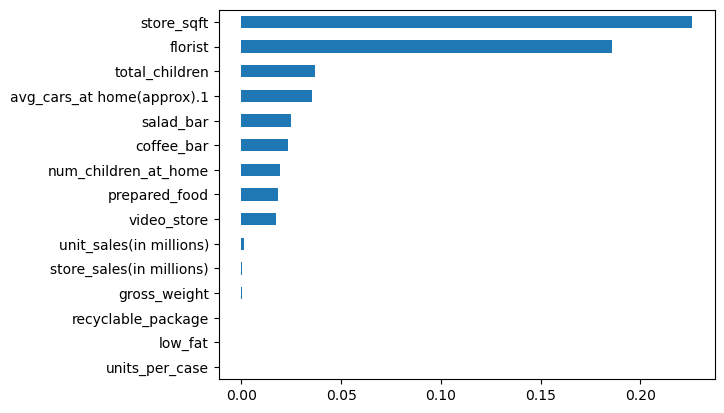

In [21]:
fi.plot(kind = 'barh')

In [22]:
#| export
features = list(fi.index)
cols_to_drop = features[0:6]

In [23]:
#| export
df_train = df_train.drop(columns=cols_to_drop)

In [24]:
#| export
df_test = df_test.drop(columns=cols_to_drop)

In [25]:
#| export
def fe(data):
    data = data.replace([np.inf, -np.inf], 10)
    return data

In [26]:
#| export
train_fe = fe(df_train)
test_fe = fe(df_test)

In [27]:
#| export
train = train_fe.drop(columns=['cost'])

In [28]:
#| export
target = train_fe['cost']

#### Finding the Best Parameters With Optuna

In [29]:
#| export
x_train, x_test, y_train, y_test = train_test_split(train,target, test_size = 0.2)
d_train = xgb.DMatrix(x_train,y_train)
d_test = xgb.DMatrix(x_test,y_test)


In [30]:
#| export
glob_params = {
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle'
}

In [31]:
#| export
def objective(trial):
    params = {
        'verbosity':0,
        'learning_rate': trial.suggest_float('learning_rate',1e-10,1.0),
        'max_depth':trial.suggest_int('max_depth', 3, 12),
#        'gamma':trial.suggest_float('gamma',0,8),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree',1e-5,1.0),
        'min_child_weight':trial.suggest_int('min_child_weight',0,1),
        'booster':trial.suggest_categorical("booster", ["dart", "gbtree",'gblinear']),
        'sampling_method': trial.suggest_categorical('sampling_method',['uniform','gradient_based']),
        'grow_policy': trial.suggest_categorical('grow_policy',['depthwise','lossguide']),
#         'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
#         'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),    
    }
    num_boost_round = params.pop('num_boost_round')
    params.update(glob_params)
    sch_prm = xgb.train(params, d_train, num_boost_round=200,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score


In [32]:
#| export
run_study = False

In [33]:
#| export
if run_study == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials = 100,)
    # save study.best_params a json file to load later
    with open('./training_params/xgb_params.json', 'w') as fp:
        json.dump(study.best_params, fp)

#### Assigning Best Parameters

In [34]:
#| export
with open('./training_params/xgb_params.json', 'r') as fp:
    study_best_params = json.load(fp)

In [35]:
study_best_params

{'learning_rate': 0.9966089304842916,
 'max_depth': 12,
 'lambda': 0.36999767740684797,
 'alpha': 0.00034306004800048104,
 'colsample_bytree': 0.9657745153267124,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise'}

In [36]:
#| export
best_params = {
 'learning_rate': 0.9319687783879956,
 'max_depth': 12,
 'lambda': 0.02022953533538882,
 'alpha': 9.277352577569814e-07,
 'colsample_bytree': 0.7477567097593131,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [37]:
#| export
best_params.update(study_best_params)

In [38]:
def max_boost_round(trial):
    params = {
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1500),
    }
    num_boost_round = params.pop('num_boost_round')
    params.update(glob_params)
    sch_prm = xgb.train(params, d_train, num_boost_round=num_boost_round,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score

In [39]:
run_max_boost = False

In [40]:
#| export
if run_max_boost == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(max_boost_round, n_trials = 20,)
    # save study.best_params a json file to load later
    with open('./training_params/boost_params.json', 'w') as fp:
        json.dump(study.best_params, fp)

In [41]:
#| export
with open('./training_params/boost_params.json', 'r') as fp:
    boost_best_params = json.load(fp)

In [42]:
num_boost_round = boost_best_params['num_boost_round']

***

#### Creating GB Model

In [43]:
#| export
cont, cat = cont_cat_split(df_train, max_card=1, dep_var='cost')

In [44]:
to = TabularPandas(df_train, procs, cat, cont, y_names='cost', splits=splits)

In [45]:
to_test = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)

In [46]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
test_xs = to_test.xs

In [47]:
gb_train = xgb.DMatrix(xs, label=y)
gb_valid = xgb.DMatrix(valid_xs, label=valid_y)
gb_test = xgb.DMatrix(test_xs)

In [48]:
# # use best params in xgb.train
# model =  xgb.train(best_params, gb_train, num_boost_round = num_boost_round,
#                         evals = [(gb_valid, 'valid')], 
#                         early_stopping_rounds=20, verbose_eval=True
#                        )

[0]	valid-rmsle:3.58321
[1]	valid-rmsle:3.01015
[2]	valid-rmsle:2.45605
[3]	valid-rmsle:1.92735
[4]	valid-rmsle:1.43401
[5]	valid-rmsle:0.99259
[6]	valid-rmsle:0.63211
[7]	valid-rmsle:0.40101
[8]	valid-rmsle:0.31917
[9]	valid-rmsle:0.30638
[10]	valid-rmsle:0.30301
[11]	valid-rmsle:0.30105
[12]	valid-rmsle:0.30037
[13]	valid-rmsle:0.29942
[14]	valid-rmsle:0.29894
[15]	valid-rmsle:0.29825
[16]	valid-rmsle:0.29787
[17]	valid-rmsle:0.29763
[18]	valid-rmsle:0.29737
[19]	valid-rmsle:0.29706
[20]	valid-rmsle:0.29665
[21]	valid-rmsle:0.29639
[22]	valid-rmsle:0.29613
[23]	valid-rmsle:0.29591
[24]	valid-rmsle:0.29581
[25]	valid-rmsle:0.29562
[26]	valid-rmsle:0.29553
[27]	valid-rmsle:0.29533
[28]	valid-rmsle:0.29521
[29]	valid-rmsle:0.29504
[30]	valid-rmsle:0.29494
[31]	valid-rmsle:0.29483
[32]	valid-rmsle:0.29474
[33]	valid-rmsle:0.29465
[34]	valid-rmsle:0.29461
[35]	valid-rmsle:0.29451
[36]	valid-rmsle:0.29445
[37]	valid-rmsle:0.29439
[38]	valid-rmsle:0.29430
[39]	valid-rmsle:0.29426
[40]	valid

#### Getting GB Predictions

In [ ]:
# xgb_preds = model.predict(xgb.DMatrix(test_xs))

In [ ]:
# np.savetxt('./predictions/xgb_preds.csv', xgb_preds, delimiter=',')

In [ ]:
# xgb_preds = np.loadtxt('./predictions/xgb_preds.csv', delimiter=',')

In [ ]:
# xgb_preds

array([ 90.8746109 ,  94.17379761,  94.01966095, ...,  94.01966095,
       105.49355316, 110.67835999])

***

#### XGB K-Folds Cross Validation

In [49]:
k_folds_train = False

In [50]:
if k_folds_train == True:
    # set the number of folds
    num_folds = 10
    # create empty list to store the loglosses
    loglosses = []
    # create empty array to store the predictions
    k_gb_preds = np.zeros(len(to_test))
    # create a kfold object
    kf = KFold(n_splits=num_folds, shuffle = True, random_state = 1042)
    # loop through each fold
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X=xs, y=y)):
        # print the fold number
        print('-'*20, 'Fold:', fold + 1, '-'*20)
        # split the data into train and validation
        X_train, X_test = train.iloc[trn_idx], train.iloc[val_idx]
        # split the target into train and validation
        y_train, y_test = target.iloc[trn_idx], target.iloc[val_idx]
        
        # create the train and validation data
        d_train = xgb.DMatrix(X_train,y_train)
        d_test = xgb.DMatrix(X_test,y_test)
        
        # train the model
        k_gb_model =  xgb.train(best_params, d_train, num_boost_round = num_boost_round,
                            evals = [(d_test, 'valid')], 
                            early_stopping_rounds=20, verbose_eval=True
                        )
    #     preds = model.predict(d_test)
    #     logloss = metrics.log_loss(y_test, preds)
    #     loglosses.append(logloss)
    #     print(f'Logloss: {logloss}')
        # predict on the test set
        preds = k_gb_model.predict(xgb.DMatrix(test_xs))
        # add the predictions to the final predictions array
        k_gb_preds += preds / num_folds

    # save k_gb_preds to csv
    np.savetxt('./predictions/k_gb_preds.csv', k_gb_preds, delimiter=',')

In [51]:
if 'k_gb_preds' not in locals():
    k_gb_preds = np.loadtxt('./predictions/k_gb_preds.csv', delimiter=',')

In [52]:
k_gb_preds

array([103.21230888,  73.93023109,  99.01429653, ...,  99.01429653,
        77.44030571, 104.49899864])

In [53]:
Path('./xgb_submissions').mkdir(exist_ok=True, parents=True)
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df['cost'] = k_gb_preds
sample_df.to_csv('./xgb_submissions/submission.csv', index=False)

In [59]:
!head ./xgb_submissions/submission.csv

id,cost
360336,103.21230888366699
360337,73.93023109436035
360338,99.01429653167725
360339,77.59238004684448
360340,83.76873779296875
360341,75.63959503173828
360342,64.36002445220947
360343,75.63959503173828
360344,76.54927587509155


In [55]:
new_sub_nums = sample_df['cost'].to_numpy()
benchmark_df = pd.read_csv('benchmark_submission.csv')
benchmark_nums = benchmark_df['cost'].to_numpy()
diffs = np.mean(np.abs(new_sub_nums - benchmark_nums))

In [56]:
diffs

9.70093078572338

In [63]:
submit = True

In [64]:
if not iskaggle and submit:
    from kaggle import api
    api.competition_submit_cli(file_name='./xgb_submissions/submission.csv', message="xgb_model", competition=comp)

100%|██████████| 5.79M/5.79M [00:02<00:00, 2.33MB/s]


In [68]:
current_model = 'xgb_model'

In [69]:
submission_history = api.competitions_submissions_list(id=comp)
submission_recent = [x for x in submission_history if x['description'] == current_model]
most_recent_submission = max(submission_recent, key=lambda x: x['date'])
if most_recent_submission['publicScore'] is not None:
    current_model = most_recent_submission['description']
    current_score = most_recent_submission['publicScore']

    if not os.path.exists('model_scores.csv'):
        with open('model_scores.csv', "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["model", "current_score"])

    model_score_df = pd.read_csv('./model_scores.csv')

    if current_model in model_score_df['model'].values:
        model_score_df.loc[model_score_df['model'] == current_model, 'current_score'] = current_score
    else:
        new_row = pd.DataFrame({"model": [current_model], "current_score": [current_score]})
        model_score_df = pd.concat([model_score_df, new_row], ignore_index=True)
        
    pd.DataFrame(model_score_df).to_csv('./model_scores.csv', index=False)

In [70]:
current_score

'0.34375'

In [ ]:
import nbdev
nbdev.export.nb_export('rf_model.ipynb', 'rf_model')
print("export successful")